In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import statistics
from scipy.stats import pearsonr
import networkx as nx
from tqdm import tqdm
import requests
from datetime import datetime

### Загрузка данных

In [3]:
btc = pd.read_parquet(r'C:\Users\Эвелина Новикова\Documents\Downloads\binance-futures_book_snapshot_25_2024-11-01_BTCUSDT.parquet')
eth = pd.read_parquet(r'C:\Users\Эвелина Новикова\Documents\Downloads\binance-futures_book_snapshot_25_2024-11-01_ETHUSDT.parquet')
mew = pd.read_parquet(r'C:\Users\Эвелина Новикова\Documents\Downloads\binance-futures_book_snapshot_25_2024-11-01_MEWUSDT.parquet')
sol = pd.read_parquet(r'C:\Users\Эвелина Новикова\Documents\Downloads\binance-futures_book_snapshot_25_2024-11-01_SOLUSDT.parquet')
pep = pd.read_parquet(r'C:\Users\Эвелина Новикова\Documents\Downloads\binance-futures_book_snapshot_25_2024-11-01_1000PEPEUSDT.parquet')

### Пример того, в каком виде у нас данные:

In [187]:
sol.head()

,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,bids[1].price,bids[1].amount,asks[2].price,asks[2].amount,...,bids[22].amount,asks[23].price,asks[23].amount,bids[23].price,bids[23].amount,asks[24].price,asks[24].amount,bids[24].price,bids[24].amount,mid
local_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-11-01 00:00:01.047517,168.63,264,168.62,255,168.64,61,168.61,92,168.65,121,...,728,168.86,480,168.4,2998,168.87,654,168.39,359,168.625
2024-11-01 00:00:01.616655,168.63,264,168.62,255,168.64,61,168.61,92,168.65,121,...,728,168.86,480,168.4,2998,168.87,654,168.39,359,168.625
2024-11-01 00:00:01.717080,168.63,264,168.62,255,168.64,61,168.61,92,168.65,121,...,728,168.86,480,168.4,2998,168.87,654,168.39,359,168.625
2024-11-01 00:00:01.860714,168.63,264,168.62,255,168.64,61,168.61,92,168.65,121,...,728,168.86,480,168.4,2998,168.87,654,168.39,359,168.625
2024-11-01 00:00:02.410507,168.63,264,168.62,255,168.64,61,168.61,92,168.65,121,...,728,168.86,480,168.4,2998,168.87,654,168.39,359,168.625


In [4]:
# расшифровка временной метки
NANOSECOND = 1
MICROSECOND = 1000
MILLISECOND = 1000000
SECOND = 1000000000

### Предварительная обработка данных

In [192]:
# создаём столбец mid price
btc['mid'] = (btc['asks[0].price'] + btc['bids[0].price'])/2
eth['mid'] = (eth['asks[0].price'] + eth['bids[0].price'])/2
mew['mid'] = (mew['asks[0].price'] + mew['bids[0].price'])/2
sol['mid'] = (sol['asks[0].price'] + sol['bids[0].price'])/2
pep['mid'] = (pep['asks[0].price'] + pep['bids[0].price'])/2

In [5]:
# преобразование временной метки
eth['local_timestamp'] = pd.to_datetime(eth['local_timestamp'], unit='us')
btc['local_timestamp'] = pd.to_datetime(btc['local_timestamp'], unit='us')
pep['local_timestamp'] = pd.to_datetime(pep['local_timestamp'], unit='us')
mew['local_timestamp'] = pd.to_datetime(mew['local_timestamp'], unit='us')
sol['local_timestamp'] = pd.to_datetime(sol['local_timestamp'], unit='us')

In [7]:
mini_btc = btc[:500]

In [15]:
btc_table = pa.Table.from_pandas(mini_btc)
pq.write_table(btc_table, 'mini_btc.parquet')

In [55]:
# определение самого длинного датасета
lens = {'BTC' : len(btc), 
        'ETH' : len(eth), 
        'MEW' : len(mew),
        'PEPE': len(pep),
        'SOL' : len(sol)}
list(max(lens.items()))[0]

'SOL'

In [11]:
# создание временной шкалы (используем минимальное и максимальное время из датасета SOL)
start_time = sol['local_timestamp'].min()
end_time = sol['local_timestamp'].max()

# интервал в микросекундах (устанавливаем на 1000 микросекунд = 1 милисекунда)
interval = 1000

# Создание общей временной шкалы
common_time_index = pd.date_range(start=start_time, end=end_time, freq=f'{interval}us')

In [13]:
# Функция для ресэмплинга и интерполяции данных
def resample_to_common_timeline(df, common_time_index, value_col):
    df = df.set_index('local_timestamp')
    resampled_df = df[value_col].reindex(common_time_index).interpolate(method='linear')
    return resampled_df

In [61]:
# Ресэмплинг данных каждого инструмента
resampled_eth = resample_to_common_timeline(eth, common_time_index, 'mid')
resampled_mew = resample_to_common_timeline(mew, common_time_index, 'mid')
resampled_sol = resample_to_common_timeline(sol, common_time_index, 'mid')
resampled_pep = resample_to_common_timeline(pep, common_time_index, 'mid')
resampled_btc = resample_to_common_timeline(btc, common_time_index, 'mid')

In [62]:
# Объединение всех данных в один датафрейм
combined_df = pd.DataFrame({
    'ETH': resampled_eth,
    'MEW': resampled_mew,
    'SOL': resampled_sol,
    'PEPE': resampled_pep,
    'BTC': resampled_btc
})

In [63]:
# Проверка, что индексы совпадают
combined_df.index.name = 'timestamp'

In [64]:
# Удаление строк, где все значения NaN (если временные метки вообще не пересекались)
combined_df.dropna(how='all', inplace=True)

In [65]:
# Подсчет количества пропущенных значений в каждой колонке
missing_values_count = combined_df.isna().sum()
missing_values_count

ETH     54348
MEW     96339
SOL         0
PEPE    31327
BTC      6405
dtype: int64

In [66]:
# Заполнение предыдущими значениями
combined_df.ffill(inplace=True)

# Если остались NaN в начале, заполним их последующими значениями
combined_df.bfill(inplace=True)
combined_df

,ETH,MEW,SOL,PEPE,BTC
timestamp,,,,,
2024-11-01 00:00:01.047517,2518.575,0.009090,168.625000,0.009118,70313.85
2024-11-01 00:00:01.048517,2518.575,0.009090,168.624994,0.009118,70313.85
2024-11-01 00:00:01.049517,2518.575,0.009090,168.624987,0.009118,70313.85
2024-11-01 00:00:01.050517,2518.575,0.009090,168.624981,0.009118,70313.85
2024-11-01 00:00:01.051517,2518.575,0.009090,168.624975,0.009118,70313.85
...,...,...,...,...,...
2024-11-01 23:59:59.966517,2512.185,0.009328,166.075000,0.008882,69512.55
2024-11-01 23:59:59.967517,2512.185,0.009328,166.075000,0.008882,69512.55
2024-11-01 23:59:59.968517,2512.185,0.009328,166.075000,0.008882,69512.55


### Визуализация

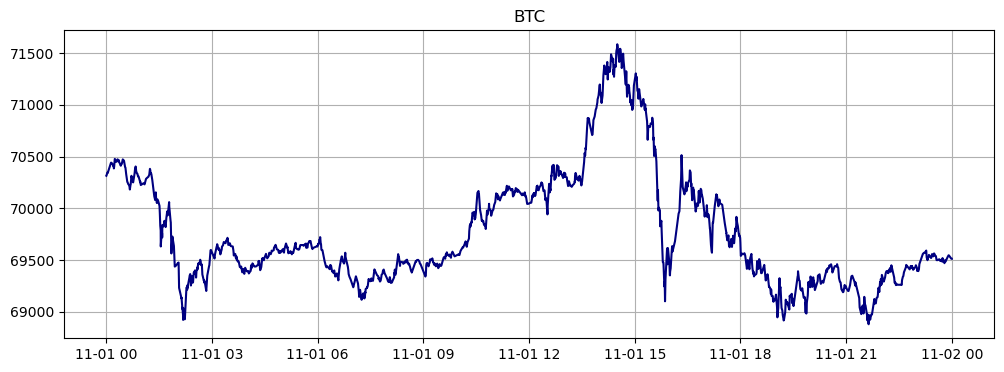

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(combined_df['BTC'], color = 'navy')
plt.title('BTC')
plt.grid(True)
plt.show()

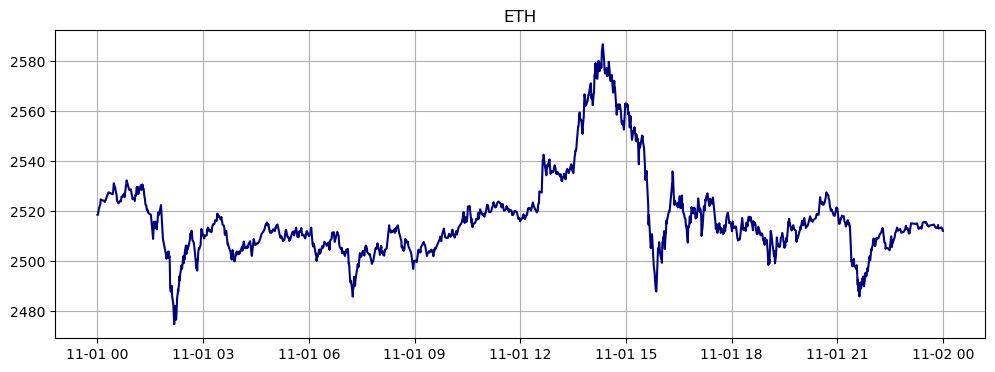

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(combined_df['ETH'], color = 'navy')
plt.title('ETH')
plt.grid(True)
plt.show()

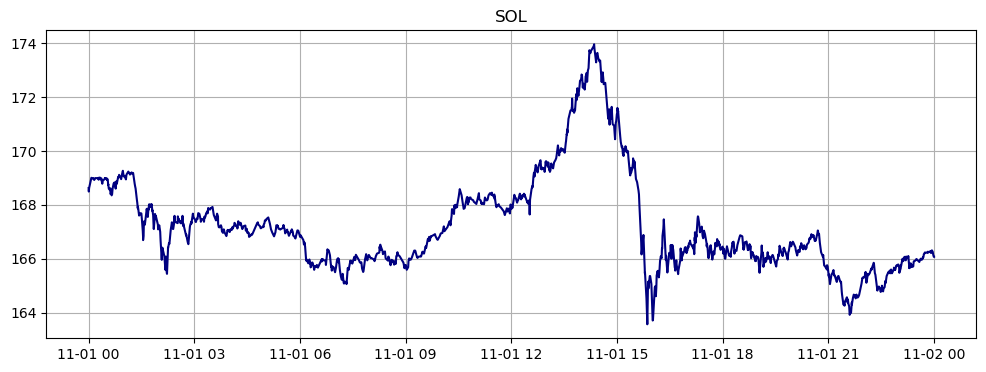

In [28]:
plt.figure(figsize=(12, 4))
plt.plot(combined_df['SOL'], color = 'navy')
plt.title('SOL')
plt.grid(True)
plt.show()

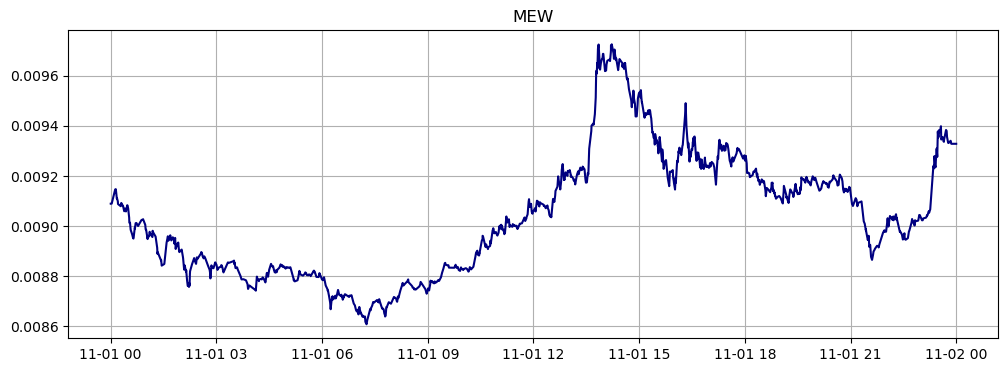

In [59]:
plt.figure(figsize=(12, 4))
plt.plot(combined_df['MEW'], color = 'navy')
plt.title('MEW')
plt.grid(True)
plt.show()

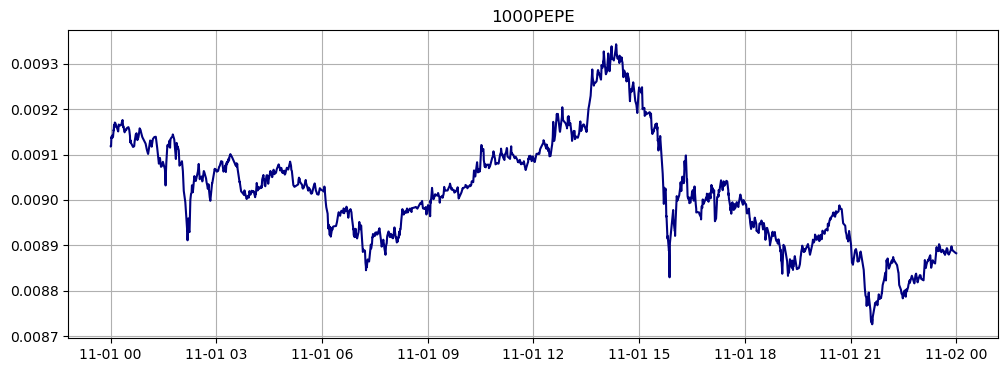

In [61]:
plt.figure(figsize=(12, 4))
plt.plot(combined_df['PEPE'], color = 'navy')
plt.title('1000PEPE')
plt.grid(True)
plt.show()

### Корреляционный анализ

In [24]:
def calculate_lagged_correlation(series1, series2, max_lag):
    lags = np.arange(-max_lag, max_lag + 1)
    correlations = []

    for lag in lags:
        if lag < 0:
            corr, _ = pearsonr(series1[:lag], series2[-lag:])
        elif lag > 0:
            corr, _ = pearsonr(series1[lag:], series2[:-lag])
        else:
            corr, _ = pearsonr(series1, series2)
        correlations.append(corr)

    best_lag = lags[np.argmax(np.abs(correlations))]
    best_correlation = correlations[np.argmax(np.abs(correlations))]
    return lags, correlations, best_lag, best_correlation

In [25]:
# Параметр максимального лага (в шагах временной шкалы)
max_lag = 1000  # Максимальное количество сдвигов для анализа

# Взятие случайного временного интервала в размере 1% от общей выборки
sampled_df = combined_df.sample(frac=0.01, random_state=4).sort_index()

# Определение пар инструментов и вычисление лага и корреляции
instruments = ['BTC', 'PEPE', 'ETH', 'SOL', 'MEW']
results = []

Вычисление корреляций: 100%|████████████████████████████████████████████████████████████| 5/5 [12:05<00:00, 145.10s/it]


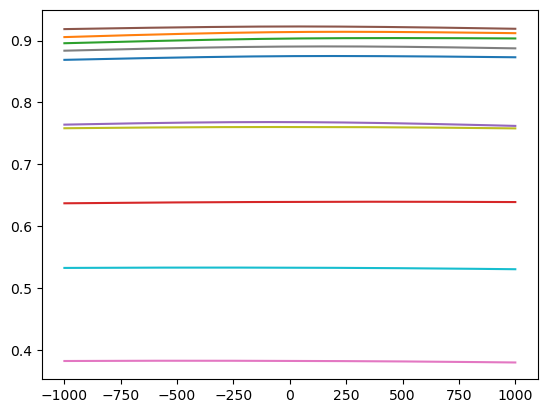

In [26]:
for i in tqdm(range(len(instruments)), desc="Вычисление корреляций"):
    for j in range(i + 1, len(instruments)):
        lags, correlations, best_lag, best_correlation = calculate_lagged_correlation(
            sampled_df[instruments[i]], sampled_df[instruments[j]], max_lag
        )
        results.append({
            'Instrument 1': instruments[i],
            'Instrument 2': instruments[j],
            'Best Lag': best_lag,
            'Best Correlation': best_correlation
        })
        plt.plot(lags, correlations, label=f"{instruments[i]} vs {instruments[j]}")

In [27]:
results_df = pd.DataFrame(results)
print("Lag and Correlation between Instruments:")
print(results_df)

Lag and Correlation between Instruments:
  Instrument 1 Instrument 2  Best Lag  Best Correlation
0          BTC         PEPE       182          0.875010
1          BTC          ETH       234          0.914195
2          BTC          SOL       464          0.904039
3          BTC          MEW       392          0.639368
4         PEPE          ETH       -91          0.768202
5         PEPE          SOL        38          0.922786
6         PEPE          MEW      -445          0.382253
7          ETH          SOL       173          0.890523
8          ETH          MEW       -90          0.760195
9          SOL          MEW      -360          0.532907


In [28]:
G = nx.DiGraph()
edge_labels = {}

# Добавление ребер в граф на основе результатов корреляции из results_df
for _, row in results_df.iterrows():
    name1 = row['Instrument 1']
    name2 = row['Instrument 2']
    lag = row['Best Lag']
    correlation = row['Best Correlation']

    if lag < 0:
        G.add_edge(name2, name1)  # name2 влияет на name1
        edge_labels[(name2, name1)] = f'{correlation:.2f}'
    elif lag > 0:
        G.add_edge(name1, name2)  # name1 влияет на name2
        edge_labels[(name1, name2)] = f'{correlation:.2f}'

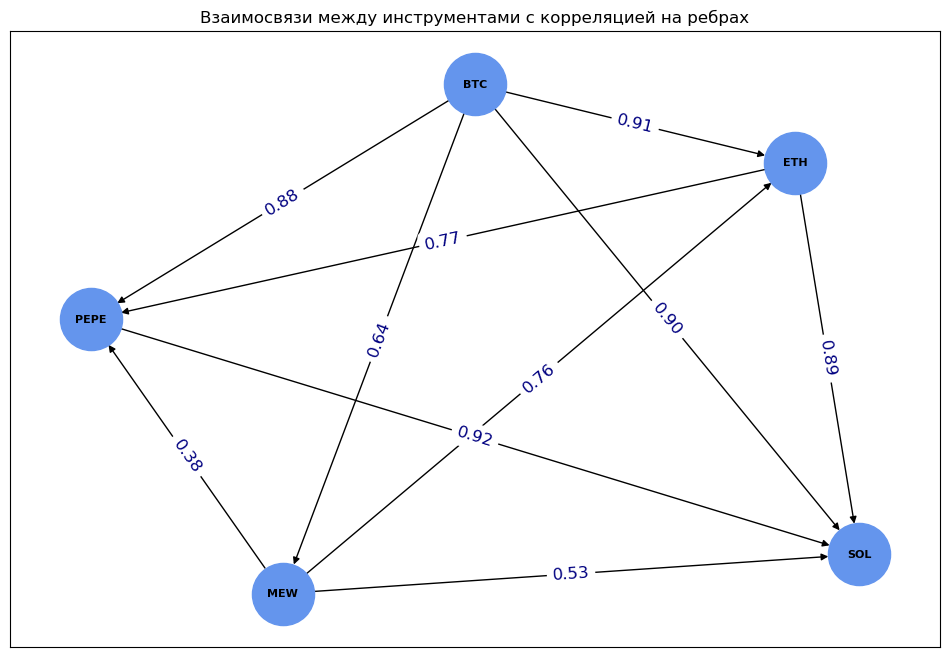

Доминирующий инструмент: BTC


In [29]:
plt.figure(figsize=(12, 8))

# Определение фиксированных позиций для узлов (в соответствии с инструментами из combined_df)
fixed_positions = {
    'BTC': [0.1, 0.8],
    'PEPE': [-0.5, 0.2],
    'ETH': [0.6, 0.6],
    'MEW': [-0.2, -0.5],
    'SOL': [0.7, -0.4]
}

# Построение графа с учетом фиксации позиций
nx.draw_networkx(G, pos=fixed_positions, with_labels=True, node_size=2000, node_color='cornflowerblue', font_size=8, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos=fixed_positions, edge_labels=edge_labels, font_size=12, font_color='navy')

# Заголовок для графа
plt.title("Взаимосвязи между инструментами с корреляцией на ребрах")
plt.show()

# Определение доминирующего инструмента
dominant_instrument = max(G.out_degree, key=lambda x: x[1])[0]
print(f"Доминирующий инструмент: {dominant_instrument}")

# Подготовка данных к извлечению фичей

In [197]:
sol = sol.set_index('local_timestamp')
eth = eth.set_index('local_timestamp')
btc = btc.set_index('local_timestamp')
mew = mew.set_index('local_timestamp')
pep = pep.set_index('local_timestamp')

In [225]:
best_bid_sol_p = sol['bids[0].price'].resample('100ms').ffill()
best_bid_sol_p = best_bid_sol_p.dropna()
best_ask_sol_p = sol['asks[0].price'].resample('100ms').ffill()
best_ask_sol_p = best_ask_sol_p.dropna()
best_bid_sol_q = sol['bids[0].amount'].resample('100ms').ffill()
best_bid_sol_q = best_bid_sol_q.dropna()
best_ask_sol_q = sol['asks[0].amount'].resample('100ms').ffill()
best_ask_sol_q = best_ask_sol_q.dropna()

In [227]:
best_level = pd.DataFrame({'best_bid_sol_p': best_bid_sol_p,
                           'best_ask_sol_p': best_ask_sol_p,
                           'best_bid_sol_q': best_bid_sol_q,
                           'best_ask_sol_q': best_ask_sol_q})

In [229]:
mid_sol = sol['mid'].resample('100ms').ffill()
mid_sol = mid_sol.dropna()
mid_eth = eth['mid'].resample('100ms').ffill()
mid_eth = mid_eth.dropna()
mid_mew = mew['mid'].resample('100ms').ffill()
mid_mew = mid_mew.dropna()
mid_btc = btc['mid'].resample('100ms').ffill()
mid_btc = mid_btc.dropna()
mid_pep = pep['mid'].resample('100ms').ffill()
mid_pep = mid_pep.dropna()

In [231]:
df_sol = pd.DataFrame(mid_sol)
df_mew = pd.DataFrame(mid_mew)
df_pep = pd.DataFrame(mid_pep)
df_btc = pd.DataFrame(mid_btc)
df_eth = pd.DataFrame(mid_eth)

In [233]:
df_mew = df_mew.rename(columns={'mid': 'MEW'})

In [235]:
new_sol = df_sol[:len(df_sol)-(len(df_sol) - len(df_mew))]
new_btc = df_btc[:len(df_btc)-(len(df_btc) - len(df_mew))]
new_pep = df_pep[:len(df_pep)-(len(df_pep) - len(df_mew))]
new_eth = df_eth[:len(df_eth)-(len(df_eth) - len(df_mew))]

In [237]:
df_mew['BTC'] = new_btc['mid']
df_mew['SOL'] = new_sol['mid']
df_mew['PEPE'] = new_pep['mid']
df_mew['ETH'] = new_eth['mid']

In [239]:
df = df_mew.dropna()

In [241]:
df = df.join(best_level, how = 'left')

In [243]:
df

,MEW,BTC,SOL,PEPE,ETH,best_bid_sol_p,best_ask_sol_p,best_bid_sol_q,best_ask_sol_q
local_timestamp,,,,,,,,,
2024-11-01 00:00:04.100,0.009051,70321.95,168.625,0.009116,2518.375,168.62,168.63,175.0,264.0
2024-11-01 00:00:04.200,0.009053,70321.95,168.625,0.009118,2518.375,168.62,168.63,203.0,298.0
2024-11-01 00:00:04.300,0.009053,70321.95,168.635,0.009118,2518.365,168.63,168.64,580.0,96.0
2024-11-01 00:00:04.400,0.009054,70321.95,168.635,0.009117,2518.285,168.63,168.64,637.0,240.0
2024-11-01 00:00:04.500,0.009056,70317.65,168.635,0.009117,2518.185,168.63,168.64,616.0,369.0
...,...,...,...,...,...,...,...,...,...
2024-11-01 23:59:56.200,0.009295,69502.15,166.035,0.008882,2511.985,166.03,166.04,148.0,632.0
2024-11-01 23:59:56.300,0.009295,69502.15,166.035,0.008882,2511.985,166.03,166.04,115.0,632.0
2024-11-01 23:59:56.400,0.009295,69502.15,166.035,0.008882,2511.985,166.03,166.04,115.0,632.0


In [245]:
df_table = pa.Table.from_pandas(df)
pq.write_table(df_table, '100ms.parquet')

### Парсинг рыночных данных (SOLUSDT)

In [17]:
def get_historical_trades(symbol='SOLUSDT', start_time=None, end_time=None, limit=1000):
    url = "https://api.binance.com/api/v3/aggTrades"
    params = {
        'symbol': symbol,
        'limit': limit,
    }
    if start_time:
        params['startTime'] = int(pd.Timestamp(start_time).timestamp() * 1000)
    if end_time:
        params['endTime'] = int(pd.Timestamp(end_time).timestamp() * 1000)
    
    response = requests.get(url, params=params)
    trades = response.json()
    df = pd.DataFrame(trades)
    df['time'] = pd.to_datetime(df['T'], unit='ms')
    df['price'] = df['p'].astype(float)
    df['volume'] = df['q'].astype(float)
    return df[['time', 'price', 'volume', 'f', 'l', 'm']]


def fetch_all_trades(symbol, start_time, end_time):
    all_trades = []
    current_time = pd.Timestamp(start_time)
    end_time = pd.Timestamp(end_time)
    
    while current_time < end_time:
        chunk = get_historical_trades(
            symbol=symbol,
            start_time=current_time,
            end_time=current_time + pd.Timedelta(hours=1),  # Разбиваем по часам
            limit=1000
        )
        if not chunk.empty:
            all_trades.append(chunk)
            current_time = chunk['time'].iloc[-1] + pd.Timedelta(milliseconds=1)
        else:
            current_time += pd.Timedelta(hours=1)
    
    return pd.concat(all_trades)

trades_full_day = fetch_all_trades('SOLUSDT', '2024-11-01 00:00:00', '2024-11-01 23:59:59')
trades_full_day.to_excel('C:/Users/Эвелина Новикова/Downloads/sol_trades.xlsx', index=False)

In [6]:
sol_trades = pd.read_excel('C:/Users/Эвелина Новикова/Downloads/sol_trades.xlsx')

In [8]:
df = pd.read_parquet(r'C:\Users\Эвелина Новикова\100ms_df.parquet')

In [10]:
sol_trades.head()

,timestamp,price,volume,type
0,2024-11-01 00:00:00.871,168.69,0.217,sell
1,2024-11-01 00:00:01.105,168.69,0.398,sell
2,2024-11-01 00:00:02.115,168.69,0.088,buy
3,2024-11-01 00:00:02.149,168.69,0.305,buy
4,2024-11-01 00:00:02.550,168.69,0.111,buy


In [247]:
df.head()

,MEW,BTC,SOL,PEPE,ETH,best_bid_sol_p,best_ask_sol_p,best_bid_sol_q,best_ask_sol_q
local_timestamp,,,,,,,,,
2024-11-01 00:00:04.100,0.009051,70321.95,168.625,0.009116,2518.375,168.62,168.63,175.0,264.0
2024-11-01 00:00:04.200,0.009053,70321.95,168.625,0.009118,2518.375,168.62,168.63,203.0,298.0
2024-11-01 00:00:04.300,0.009053,70321.95,168.635,0.009118,2518.365,168.63,168.64,580.0,96.0
2024-11-01 00:00:04.400,0.009054,70321.95,168.635,0.009117,2518.285,168.63,168.64,637.0,240.0
2024-11-01 00:00:04.500,0.009056,70317.65,168.635,0.009117,2518.185,168.63,168.64,616.0,369.0


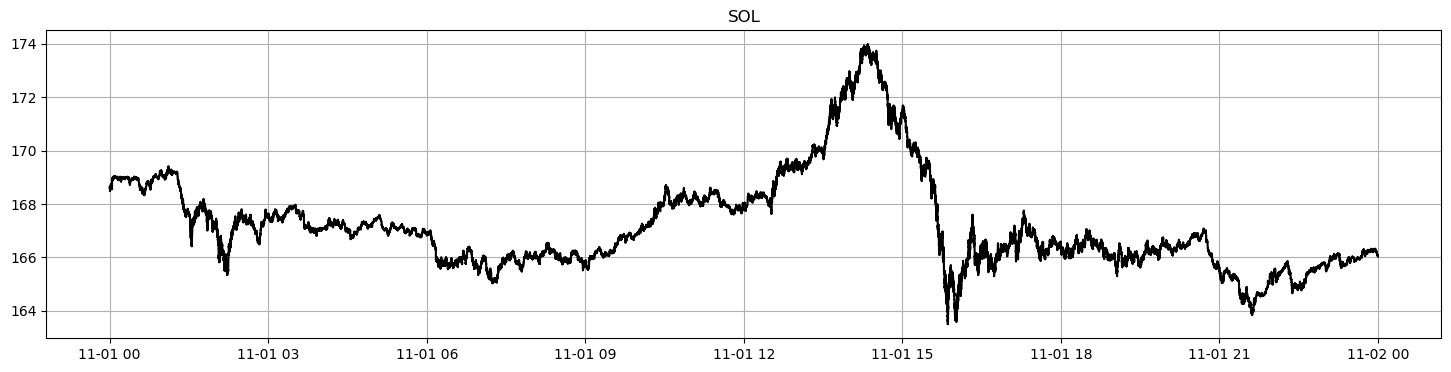

In [257]:
plt.figure(figsize=(18, 4))
plt.plot(df['SOL'], color = 'black')
plt.title('SOL')
plt.grid(True)
plt.show()

In [14]:
sol_buy = sol_trades[sol_trades['type'] == 'buy']
sol_sell = sol_trades[sol_trades['type'] == 'sell']

In [16]:
sol_buy = sol_buy.set_index('timestamp')
sol_sell = sol_sell.set_index('timestamp')

In [18]:
start_agg = pd.Timestamp("2024-11-01 00:00:04.100")

In [20]:
ohlcv_buy = sol_buy.resample("100ms", origin=start_agg).agg({
    "price": ["first", "max", "min", "last"],
    "volume": "sum"})

ohlcv_sell = sol_sell.resample("100ms", origin=start_agg).agg({
    "price": ["first", "max", "min", "last"],
    "volume": "sum"})

ohlcv_buy.columns = ["open_b", "high_b", "low_b", "close_b", "volume_b"]
ohlcv_sell.columns = ["open_s", "high_s", "low_s", "close_s", "volume_s"]

In [22]:
ohlcv_buy.ffill(inplace=True)
ohlcv_sell.ffill(inplace=True)

In [24]:
result1 = df.join(ohlcv_buy, how='left').dropna()

In [28]:
joined_df = result1.join(ohlcv_sell, how='left')

### Сохранение итоговых данных

In [144]:
joined_df.head()

,MEW,BTC,SOL,PEPE,ETH,open_b,high_b,low_b,close_b,volume_b,open_s,high_s,low_s,close_s,volume_s
local_timestamp,,,,,,,,,,,,,,,
2024-11-01 00:00:04.100,0.009051,70321.95,168.625,0.009116,2518.375,168.69,168.69,168.69,168.69,0.000,168.68,168.68,168.68,168.68,38.121
2024-11-01 00:00:04.200,0.009053,70321.95,168.625,0.009118,2518.375,168.68,168.68,168.68,168.68,19.837,168.68,168.68,168.68,168.68,0.000
2024-11-01 00:00:04.300,0.009053,70321.95,168.635,0.009118,2518.365,168.68,168.68,168.68,168.68,0.000,168.68,168.68,168.68,168.68,0.000
2024-11-01 00:00:04.400,0.009054,70321.95,168.635,0.009117,2518.285,168.68,168.68,168.68,168.68,0.110,168.68,168.68,168.68,168.68,0.000
2024-11-01 00:00:04.500,0.009056,70317.65,168.635,0.009117,2518.185,168.68,168.68,168.68,168.68,0.000,168.68,168.68,168.68,168.68,0.000


In [32]:
joined_table = pa.Table.from_pandas(joined_df)
pq.write_table(joined_table, 'joined_df.parquet')

# Feature Engeneerig

In [3]:
joined_df = pd.read_parquet(r'C:\Users\Эвелина Новикова\joined_df.parquet')

## LOB Features

### 1. Mid price (lagged)

In [36]:
mid = joined_df['SOL']
mid.isna().sum()

0

### 2. Spread

In [64]:
resampled_bids = sol['bids[0].price'].resample('100ms').ffill()
resampled_bids = resampled_bids.dropna()

In [68]:
resampled_asks = sol['asks[0].price'].resample('100ms').ffill()
resampled_asks = resampled_asks.dropna()

In [70]:
spread = resampled_asks - resampled_bids
spread.isna().sum()

0

### 3. Отношение объёмов

In [72]:
sol['ask_vol'] = [0]*len(sol)
sol['bid_vol'] = [0]*len(sol)

In [74]:
for i in range(0, 25):
    sol['ask_vol'] += sol.iloc[:, 2 + i*4]
    sol['bid_vol'] += sol.iloc[:, 4 + i*4]

In [76]:
resampled_asks_vol = sol['ask_vol'].resample('100ms').ffill()
resampled_bids_vol = sol['bid_vol'].resample('100ms').ffill()
resampled_asks_vol = resampled_asks_vol.dropna()
resampled_bids_vol = resampled_bids_vol.dropna()

In [80]:
vol_ratio = (resampled_bids_vol - resampled_asks_vol)/(resampled_bids_vol + resampled_asks_vol)
vol_ratio.isna().sum()

0

### 4. Скорость изменения mid price

In [82]:
diff_mid = mid.diff()

In [84]:
diff_mid.bfill(inplace=True)

In [86]:
diff_mid.isna().sum()

0

### 5. Волатильность цены

In [88]:
sigma = mid.rolling(window=10).std()

In [92]:
sigma.bfill(inplace=True)

In [94]:
sigma.isna().sum()

0

### 6. Imbalance

In [98]:
def calc_imbalance(df, lvl_count):
    bids_amount = sum(
        df[f"bids[{i}].amount"]
        for i in range(lvl_count)
    )
    asks_amount = sum(
        df[f"asks[{i}].amount"]
        for i in range(lvl_count)
    )
    imbalance_value = (bids_amount - asks_amount) / (bids_amount + asks_amount)
    return imbalance_value

In [ ]:
imbalance_3_lvl = calc_imbalance(sol, 3)
imbalance_1_lvl = calc_imbalance(sol, 1)

In [37]:
sol['imb_3_lvl'] = imbalance_3_lvl
sol['imb_1_lvl'] = imbalance_1_lvl

In [100]:
imbalance_5_lvl = calc_imbalance(sol, 5)
sol['imb_5_lvl'] = imbalance_5_lvl

In [102]:
resampled_imb_5 = sol['imb_5_lvl'].resample('100ms').ffill()

In [106]:
resampled_imb_5.bfill(inplace=True)

In [108]:
resampled_imb_5.isna().sum()

0

### 7. Книжный импульс

In [110]:
impulse = resampled_imb_5.diff()

In [112]:
impulse.bfill(inplace=True)

In [114]:
impulse.isna().sum()

0

### 8. Volume-Weighted Average Price, VWAP

In [116]:
def vwap(df, lvl_count):
    ask_weighted_price = sum(
        df[f"asks[{i}].price"] * df[f"asks[{i}].amount"]
        for i in range(lvl_count)
    )
    ask_volume = sum(df[f"asks[{i}].amount"] for i in range(lvl_count))

    bid_weighted_price = sum(
        df[f"bids[{i}].price"] * df[f"bids[{i}].amount"]
        for i in range(lvl_count)
    )
    bid_volume = sum(df[f"bids[{i}].amount"] for i in range(lvl_count))

    total_weighted_price = ask_weighted_price + bid_weighted_price
    total_volume = ask_volume + bid_volume

    vwap = total_weighted_price / total_volume

    return vwap / df["mid"]

In [55]:
vwap_3_lvl = vwap(sol, 3)
vwap_1_lvl = vwap(sol, 1)

In [57]:
sol['vwap_3_lvl'] = vwap_3_lvl
sol['vwap_1_lvl'] = vwap_1_lvl

In [118]:
vwap_5_lvl = vwap(sol, 5)
sol['vwap_5_lvl'] = vwap_5_lvl

In [120]:
resampled_vwap_5 = sol['vwap_5_lvl'].resample('100ms').ffill()

### 9. Отношение скоростей прихода новых ордеров на покупку и продажу

In [122]:
diff_asks = resampled_asks_vol.diff()
diff_asks.bfill(inplace=True)
diff_bids = resampled_bids_vol.diff()
diff_bids.bfill(inplace=True)
diff_ratio = (diff_bids - diff_asks)/(diff_bids + diff_asks)

In [126]:
diff_ratio = diff_ratio.fillna(0)

In [128]:
fts_need_correct = pd.DataFrame({'spread' : spread,
                               'vol_ratio' : vol_ratio,
                               'imb_5' : resampled_imb_5,
                               'impulse' : impulse,
                               'vwap_5' : resampled_vwap_5,
                               'diff_ratio' : diff_ratio})

In [134]:
fts_no_correct = pd.DataFrame({'mid' : mid,
                             'diff_mid' : diff_mid,
                             'sigma' : sigma})

In [138]:
lob_fts = fts_no_correct.join(fts_need_correct, how = 'left')

## Trades Features

### 10. Соотношение рыночных ордеров на продажу к лимитным

In [146]:
vol = pd.DataFrame({'asks_vol': resampled_asks_vol,
                   'bids_vol': resampled_bids_vol})

In [148]:
new_joined_df = joined_df.join(vol, how='left')

In [150]:
vol_ask_rat = new_joined_df['volume_s']/new_joined_df['bids_vol']

### 11. Соотношение рыночных ордеров на покупку к лимитным

In [156]:
vol_bid_rat = new_joined_df['volume_b']/new_joined_df['bids_vol']

### 12. Order Flow Imbalance

In [158]:
ofi = (new_joined_df['volume_b'] - new_joined_df['volume_s'])/(new_joined_df['volume_b'] + new_joined_df['volume_s'])

In [160]:
ofi = ofi.fillna(0)

### Собираем все фичи в один датасет

In [162]:
trades_fts = pd.DataFrame({'ofi': ofi,
                          'vol_ask_rat': vol_ask_rat,
                          'vol_bid_rat': vol_bid_rat})

In [166]:
fts = lob_fts.join(trades_fts, how = 'left')

In [172]:
fts['eth'] = joined_df['ETH']
fts['btc'] = joined_df['BTC']
fts['pepe'] = joined_df['PEPE']
fts['mew'] = joined_df['MEW']

In [177]:
fts_table = pa.Table.from_pandas(fts)
pq.write_table(fts_table, 'fts.parquet')